In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import math
import random
random.seed(1)

## Define the pointmass environment

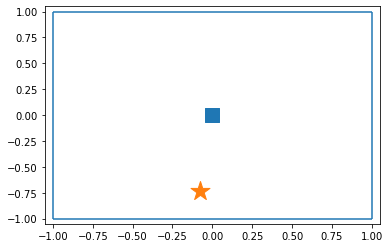

In [2]:
# @title Environment Definition
class PointmassEnv(gym.Env):
  def __init__(self):
    # 2-d coordinates
    self.observation_space = gym.spaces.Box(-1, 1, shape=(2,), dtype=np.float32)
    self.position = np.zeros(2) 
    # Up, Right, Down, Left, Stay
    self.action_space = gym.spaces.Discrete(5)

  def reset(self):
    self.position = np.zeros(2)
    return self.position

  def action_to_direction(self, a):
    actions = [
               np.array([0, 1]), # Up
               np.array([1, 0]), # Right
               np.array([0, -1]), # Down
               np.array([-1, 0]), # Left,
               np.array([0, 0]), # Stay still
    ]
    return actions[a]
  
  def step(self, a):
    direction = self.action_to_direction(a)
    step = 0.05 * direction + np.random.randn() * 0.01 # Take a noisy step in direction
    self.position = self.position + step
    self.position = np.clip(self.position, -1, 1) # Clip to prevent object from escaping
    return (self.position, # State
          0,     # Reward (not necessary for GCSL)
          False, # Done flag
          dict()) # Additional info 

  def sample_goal(self):
    return np.random.rand(2) * 2 - 1 # Sample uniformly from [-1, 1]

  def reset_pos(self, pos):
    self.position = pos
    return self.position

def plot_trajectory(trajectory, ax=None):
  if ax is None:
    ax = plt.gca()
  # Draw path
  ax.plot(*trajectory['states'].T)
  # Draw goal
  ax.scatter(0, 0, s=200, marker='s')
  ax.scatter(trajectory['desired_goal'][0], trajectory['desired_goal'][1], s=400, marker='*')
  # Draw boundary
  ax.vlines([-1, 1], -1, 1)
  ax.hlines([-1, 1], -1, 1)

  ax.set_xlim(-1.05, 1.05)
  ax.set_ylim(-1.05, 1.05)
  ax.axis('off')

env = PointmassEnv()
plot_trajectory(dict(states=env.reset()[None], desired_goal=env.sample_goal()))
plt.axis('on');

## Define the Agent
- the agent policy is a fully connected network 
- It takes in the state, goal and horizon as input

In [3]:
#@title Neural Network Agent Definition

class NNAgent(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(5, 100), # Input 2 (state) + 2 (goal) + 1 (horizon)
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 5), # Output: 5 actions
      )
  
  def forward(self, state, goal, horizon):
    horizon = horizon / 50 # Normalize between [0, 1]
    x = torch.cat([state, goal, horizon], -1)
    logits = self.net(x)
    return logits
  
  def get_action(self, state, goal, horizon):
    # Put into PyTorch Notation
    state_torch, goal_torch, horizon_torch = to_torch(state, goal, horizon)
    logits_torch = self.forward(state_torch, goal_torch, horizon_torch)[0]
    probabilities_torch = torch.softmax(logits_torch, -1)
    probabilities = probabilities_torch.detach().numpy()
    
    return np.random.choice(5, p=probabilities)

  def get_action_dist(self, state, goal, horizon):
    # Put into PyTorch Notation
    state_torch, goal_torch, horizon_torch = to_torch(state, goal, horizon)
    logits_torch = self.forward(state_torch, goal_torch, horizon_torch)[0]
    probabilities_torch = torch.softmax(logits_torch, -1)
    probabilities = probabilities_torch.detach().numpy()
    
    return probabilities
  

def to_torch(state, goal, horizon):
  state_torch = torch.tensor(state, dtype=torch.float32)[None]
  goal_torch = torch.tensor(goal, dtype=torch.float32)[None]
  horizon_torch = torch.tensor(horizon, dtype=torch.float32)[None, None]
  return state_torch, goal_torch, horizon_torch

In [4]:
# @title Agent-Environment Interaction

def sample_trajectory(env, agent, T=50):
  # Sample a target goal (fixed for episode)
  desired_goal = env.sample_goal()

  # Default control loop
  state = env.reset()
  states = []
  actions = []
  for i in range(T):
    states.append(state)

    action = agent.get_action(state=state,
                              goal=desired_goal,
                              horizon=np.array(T-i, dtype=float))
    actions.append(action)

    state, _, _, _ = env.step(action)

  return {
      'states': np.array(states),  
      'actions': np.array(actions),
      'desired_goal': desired_goal,
  }

def sample_trajectory_random(env, agent, fixed_init_state=None, T=50):
  # Sample a target goal (fixed for episode)
  desired_goal = env.sample_goal()

  # Default control loop
  if fixed_init_state == None:
    state = np.random.uniform(low=-1, high=1, size=(2,))
    state = env.reset_pos(state)
  else:
    state = env.reset_pos(fixed_init_state)
    
  states = []
  actions = []
  for i in range(T):
    states.append(state)

    action = agent.get_action(state=state,
                              goal=desired_goal,
                              horizon=np.array(T-i, dtype=float))
    actions.append(action)

    state, _, _, _ = env.step(action)

  return {
      'states': np.array(states),  
      'actions': np.array(actions),
      'desired_goal': desired_goal,
  }

In [5]:
def evaluate_agent(env, agent, n=50):
  distances = []
  for _ in range(n):
    trajectory = sample_trajectory(env, agent)
    distances.append(np.linalg.norm(trajectory['states'][-1] - trajectory['desired_goal']))
  print('Median Distance to Goal:  %.3f'% np.median(distances))
  print('Min Distance to Goal:  %.3f'% np.min(distances))
  print('Max Distance to Goal:  %.3f'% np.max(distances))

def visualize_agent(env, agent):
  fig, axes = plt.subplots(1, 5, figsize=(15, 3))
  for ax in axes:
    plot_trajectory(sample_trajectory(env, agent), ax=ax)

Median Distance to Goal:  0.854
Min Distance to Goal:  0.170
Max Distance to Goal:  1.552


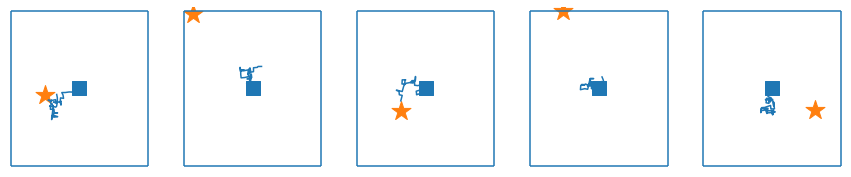

In [6]:
env = PointmassEnv()
agent = NNAgent()

evaluate_agent(env, agent)
visualize_agent(env, agent)

In [7]:
class ReachableSet():
    def __init__(self, env, env_name, width_bin=5, height_bin=5):
        self.env = env
        self.env_name = env_name
        self.width_bin= width_bin
        self.height_bin= height_bin
        self.grid = [] 
        self.obs_space_width_low, self.obs_space_height_low = self.env.observation_space.low
        self.obs_space_width_high, self.obs_space_height_high = self.env.observation_space.high

    def grid_init(self):
        for i in range(self.width_bin):
            self.grid.append([])
            for j in range(self.height_bin):
                self.grid[i].append(np.zeros((self.width_bin, self.height_bin)))
        return

    def bin_check(self, obs):
        width_index = math.ceil((obs[0] - self.obs_space_width_low) / (self.obs_space_width_high - self.obs_space_width_low) * self.width_bin) - 1
        height_index = math.ceil((obs[1] - self.obs_space_height_low) / (self.obs_space_height_high - self.obs_space_height_low) * self.height_bin) - 1
        return (max(0, width_index), max(0, height_index))

    def grid_update(self, curr_obs, next_obs):
        c_w, c_d = self.bin_check(curr_obs)
        n_w, n_d = self.bin_check(next_obs)
        self.grid[c_w][c_d][n_w][n_d] += 1
        self.grid[n_w][n_d][n_w][n_d] += 1
        return

    def grid_update_traj(self, traj):
        if len(traj) == 0:
            return
        curr_state = traj[0]
        curr_bin = self.bin_check(curr_state)
        for i, start_state in enumerate(traj):
            curr_bin = self.bin_check(start_state)
            start_bin = self.bin_check(start_state)
            s_w, s_h = start_bin
            self.grid[s_w][s_h][s_w][s_h] += 1
            for j, next_state in enumerate(traj[i:]):
                next_bin = self.bin_check(next_state)
                if next_bin == curr_bin:
                    continue
                n_w, n_h = next_bin
                self.grid[s_w][s_h][n_w][n_h] += 1
        return

    def get_reachable_set(self, state, threshold=10):
        reachable_set = []
        s_w, s_h = self.bin_check(state)
        for i in range(self.grid[s_w][s_h].shape[0]):
            for j in range(self.grid[s_w][s_h].shape[1]):
                if threshold > 0 and threshold < 1:
                    if self.grid[s_w][s_h][i][j] / np.sum(self.grid[s_w][s_h]) >= threshold:
                        reachable_set.append((i, j))
                elif threshold >= 1:
                    if self.grid[s_w][s_h][i][j] >= threshold:
                        reachable_set.append((i, j))
        return reachable_set

    def grid_init_random(self, num_sample=10, horizon=50):
        buffer = []
        if self.env_name == 'pointmass_empty':
            for i in range(num_sample):
                buffer.append([])
                state = np.random.uniform(low=-1, high=1, size=(2,))
                state = {'observation': state, 'achieved_goal': state,  'state_achieved_goal': state}
                state = self.env._base_obs_to_state(state)
                for j in range(horizon):
                    obs = self.env.observation(state)
                    action = random.randint(0, 8)
                    state, _, _, _ = self.env.step(action)
                    buffer[i].append(obs)
        elif self.env_name == 'pointmass_rooms':
            for i in range(num_sample):
                buffer.append([])
                room_num = random.randint(1, 4)
                if room_num == 1:
                    x = np.random.uniform(low=0, high=1, size=(1,))
                    y = np.random.uniform(low=-1, high=0, size=(1,))
                    state = np.array([int(x), int(y)])
                elif room_num == 2:
                    x = np.random.uniform(low=-1, high=0, size=(1,))
                    y = np.random.uniform(low=-1, high=0, size=(1,))
                    state = np.array([int(x), int(y)])
                elif room_num == 3:
                    x = np.random.uniform(low=-1, high=0, size=(1,))
                    y = np.random.uniform(low=0, high=1, size=(1,))
                    state = np.array([int(x), int(y)])
                elif room_num == 4:
                    x = np.random.uniform(low=0, high=1, size=(1,))
                    y = np.random.uniform(low=0, high=1, size=(1,))
                    state = np.array([int(x), int(y)])
                state = {'observation': state, 'achieved_goal': state,  'state_achieved_goal': state}
                state = self.env._base_obs_to_state(state)
                for j in range(horizon):
                    obs = self.env.observation(state)
                    action = random.randint(0, 8)
                    state, _, _, _ = self.env.step(action)
                    buffer[i].append(obs)
            for traj in buffer:
                self.grid_update_traj(traj)

    def get_reachable_set_center_state(self, reachable_set_current):
        reachable_set_center_state = []
        for r_state in reachable_set_current:
            r_w, r_h = r_state
            s_w = (r_w + 0.5) / self.width_bin * (self.obs_space_width_high - self.obs_space_width_low) + self.obs_space_width_low
            s_h = (r_h + 0.5) / self.height_bin * (self.obs_space_height_high - self.obs_space_height_low) + self.obs_space_height_low
            state = (s_w, s_h)
            reachable_set_center_state.append(np.array(state))
        return reachable_set_center_state

# Reachable Set Coverage

- Collect 1000 random trajectories
- Check the state coverage over the state space


In [50]:
reachable_set = ReachableSet(env, 'pointmass_empty', 50, 50)
reachable_set.grid_init()

<AxesSubplot:>

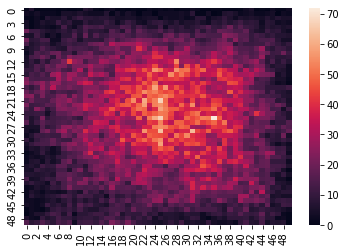

In [51]:
trajs = []
for i in range(1000):
    traj = sample_trajectory_random(env, agent)
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for traj in trajs:
    for s in traj:
        b = r.bin_check(s)
        r.grid[0][0][b[0]][b[1]] += 1
import seaborn as sns
sns.heatmap(r.grid[0][0])

<AxesSubplot:>

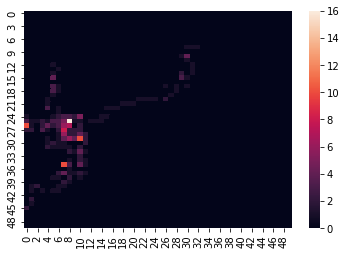

In [52]:
import seaborn as sns
sns.heatmap(reachable_set.grid[25][8])

##### Episode 0 #####
Median Distance to Goal:  0.841
Min Distance to Goal:  0.142
Max Distance to Goal:  1.324
##### Episode 40 #####
Median Distance to Goal:  0.537
Min Distance to Goal:  0.051
Max Distance to Goal:  0.975
##### Episode 80 #####
Median Distance to Goal:  0.257
Min Distance to Goal:  0.047
Max Distance to Goal:  0.585
##### Episode 120 #####
Median Distance to Goal:  0.181
Min Distance to Goal:  0.052
Max Distance to Goal:  0.667
##### Episode 160 #####
Median Distance to Goal:  0.154
Min Distance to Goal:  0.010
Max Distance to Goal:  0.473
##### Episode 200 #####
Median Distance to Goal:  0.108
Min Distance to Goal:  0.018
Max Distance to Goal:  0.454
##### Episode 240 #####
Median Distance to Goal:  0.115
Min Distance to Goal:  0.023
Max Distance to Goal:  0.432
##### Episode 280 #####
Median Distance to Goal:  0.116
Min Distance to Goal:  0.010
Max Distance to Goal:  0.264
##### Episode 320 #####
Median Distance to Goal:  0.083
Min Distance to Goal:  0.006
Max Dis

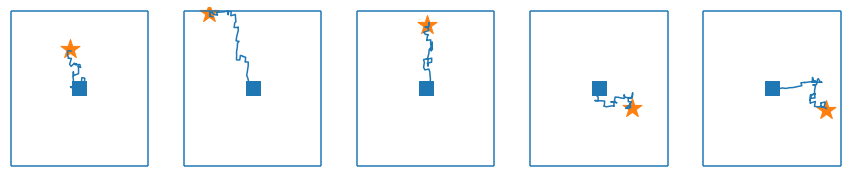

In [53]:
# Create agent and optimizer
agent = NNAgent()
learning_rate = 1e-4
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

buffer = []
n_episodes = 501
n_steps_per_episode = 500

for i in range(1000):
    traj = sample_trajectory_random(env, agent)
    reachable_set.grid_update_traj(traj['states'])
    buffer.append(traj)

for episode in range(n_episodes):
  # Collect more data and put it in the replay buffer
  # new_trajectory = sample_trajectory(env, agent)
  # buffer.append(new_trajectory)

  # GCSL optimization  
  for step in range(n_steps_per_episode):

    # Sample a trajectory and timesteps
    trajectory = buffer[np.random.choice(len(buffer))]
    t1, t2 = np.random.randint(0, 50, size=2)
    t1, t2 = min([t1, t2]), max([t1, t2])

    # Create optimal ((s, g, h), a) data
    s = trajectory['states'][t1]
    g = trajectory['states'][t2]
    h = t2 - t1
    a = trajectory['actions'][t1]

    s, g, h = to_torch(s, g, h)
    a = torch.tensor(a)[None]

    # Optimize agent(s, g, h) to imitate action a 
    optimizer.zero_grad()
    loss = nn.functional.cross_entropy(agent(s, g, h), a)
    loss.backward()
    optimizer.step()

  # Print agent performance once in a while
  if episode % 40 == 0:
    print('##### Episode %d #####'%episode)
    evaluate_agent(env, agent)

visualize_agent(env, agent)

In [54]:
dist = []
for i in range(100):
    state_org = np.random.uniform(low=-1, high=1, size=(2,))
    reach = reachable_set.get_reachable_set(state_org, threshold=1)
    reach_center = reachable_set.get_reachable_set_center_state(reach)
    goal = random.choice(reach_center)

    state = env.reset_pos(state_org)
    for j in range(50):
        action = agent.get_action(state=state,
                                goal=goal,
                                horizon=np.array(50, dtype=float))
        state, _, _, _ = env.step(action)
        if np.linalg.norm(state - state_org) <= 0.02:
            break
    dist.append(np.linalg.norm(state - state_org))
print('Median distance:', np.median(dist))


Median distance: 0.018944140932047306


[-0.94 -0.86]
[-0.86 -0.86]
[-0.74 -0.82]
[-0.62 -0.66]
[-0.78 -0.22]
[-0.74 -0.14]
[-0.78 -0.1 ]
[0.26 0.62]
[-0.14  0.3 ]
[0.5 0.5]
[0.34 0.62]
[0.38 0.58]
[0.46 0.58]
[0.58 0.58]
0.041055128134021325


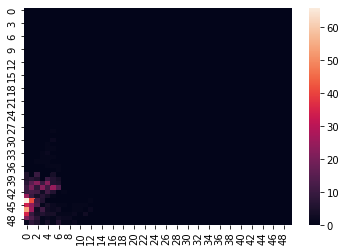

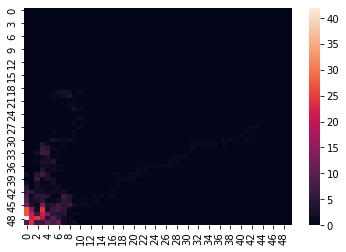

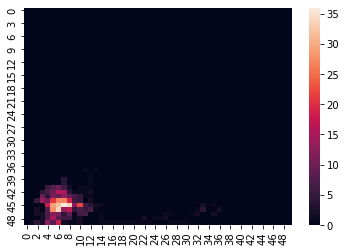

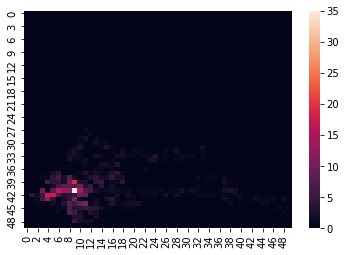

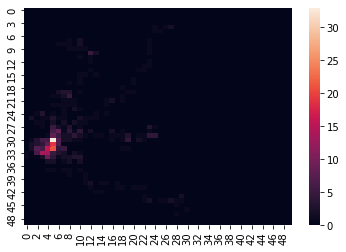

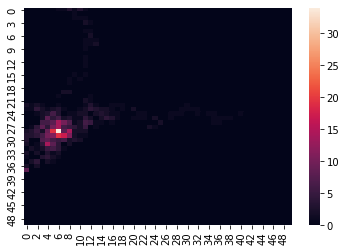

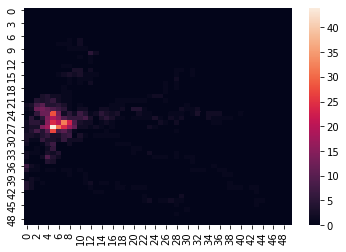

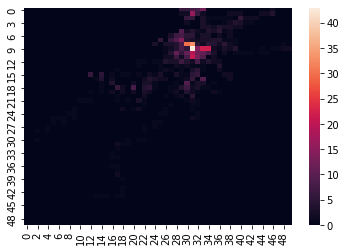

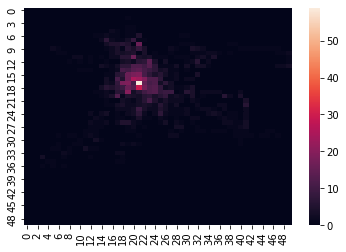

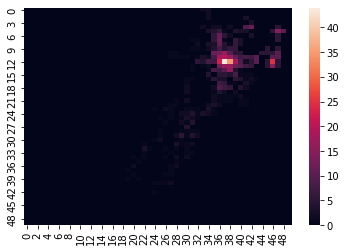

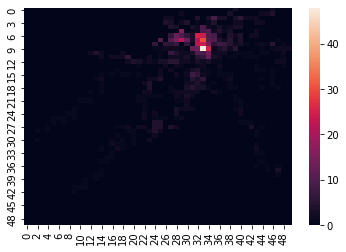

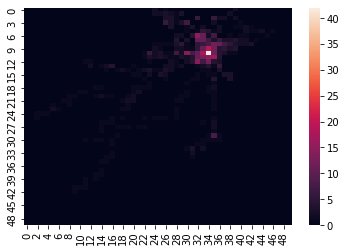

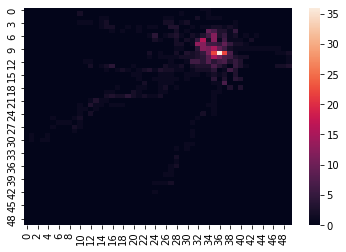

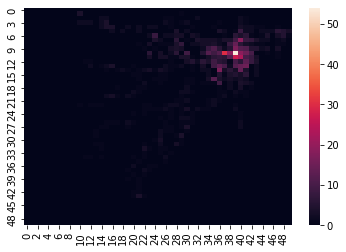

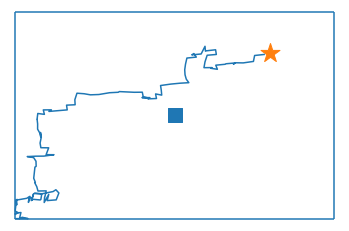

In [66]:
state = np.array([-1, -1])
goal = np.array([0.6, 0.6])

state = env.reset_pos(state)

traj = {'desired_goal': goal}
states = []
count = 1
while np.linalg.norm(state - goal) >= 0.05:
    reach = reachable_set.get_reachable_set(state, threshold=5)
    reach_center = reachable_set.get_reachable_set_center_state(reach)
    # print(reach_center)
    min_dist = np.linalg.norm(state - goal)
    min_state = [0, 0]
    for rc in reach_center:
        if np.linalg.norm(np.array(rc) - goal) <= min_dist:
            min_dist = np.linalg.norm(rc - goal)
            min_state = rc
    plt.figure(count)
    bin = reachable_set.bin_check(min_state)
    sns.heatmap(np.rot90(reachable_set.grid[bin[0]][bin[1]]))
    print(min_state)
    for j in range(10):
        action = agent.get_action(state=state,
                                    goal=min_state,
                                    horizon=np.array(10, dtype=float))
        state, _, _, _ = env.step(action)
        states.append(state)
        if np.linalg.norm(state - np.array(min_state)) <= 0.05:
            break
    count += 1
    if count >= 20:
        print("Goal is not reachable")
        break
        
traj['states'] = np.array(states)

print(np.linalg.norm(state - goal))
plt.figure(count)
plot_trajectory(traj)


## What about reachable set not realy covered cases?

In [43]:
reachable_set = ReachableSet(env, 'pointmass_empty', 50, 50)
reachable_set.grid_init()

<AxesSubplot:>

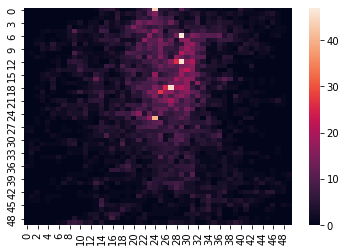

In [44]:
trajs = []
buffer = []
for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0, 0))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)

for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0.1, 0.25))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0.2, 0.5))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0.2, 0.75))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0, 1))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for traj in trajs:
    for s in traj:
        b = r.bin_check(s)
        r.grid[0][0][b[0]][b[1]] += 1

sns.heatmap(np.rot90(r.grid[0][0]))

<AxesSubplot:>

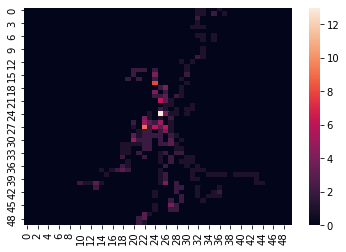

In [45]:
import seaborn as sns
sns.heatmap(np.rot90(reachable_set.grid[25][25]))

In [46]:
# Create agent and optimizer
agent = NNAgent()
learning_rate = 1e-4
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

n_episodes = 501
n_steps_per_episode = 1000

for episode in range(n_episodes):
  # Collect more data and put it in the replay buffer
  # new_trajectory = sample_trajectory(env, agent)
  # buffer.append(new_trajectory)

  # GCSL optimization  
  for step in range(n_steps_per_episode):

    # Sample a trajectory and timesteps
    trajectory = buffer[np.random.choice(len(buffer))]
    t1, t2 = np.random.randint(0, 50, size=2)
    t1, t2 = min([t1, t2]), max([t1, t2])

    # Create optimal ((s, g, h), a) data
    s = trajectory['states'][t1]
    g = trajectory['states'][t2]
    h = t2 - t1
    a = trajectory['actions'][t1]

    s, g, h = to_torch(s, g, h)
    a = torch.tensor(a)[None]

    # Optimize agent(s, g, h) to imitate action a 
    optimizer.zero_grad()
    loss = nn.functional.cross_entropy(agent(s, g, h), a)
    loss.backward()
    optimizer.step()

  # Print agent performance once in a while
  if episode % 40 == 0:
    print('##### Episode %d #####'%episode)
    evaluate_agent(env, agent)

##### Episode 0 #####
Median Distance to Goal:  0.718
Min Distance to Goal:  0.093
Max Distance to Goal:  1.745
##### Episode 40 #####
Median Distance to Goal:  0.158
Min Distance to Goal:  0.034
Max Distance to Goal:  0.365
##### Episode 80 #####
Median Distance to Goal:  0.090
Min Distance to Goal:  0.017
Max Distance to Goal:  0.285
##### Episode 120 #####
Median Distance to Goal:  0.078
Min Distance to Goal:  0.003
Max Distance to Goal:  0.175
##### Episode 160 #####
Median Distance to Goal:  0.069
Min Distance to Goal:  0.006
Max Distance to Goal:  0.175
##### Episode 200 #####
Median Distance to Goal:  0.074
Min Distance to Goal:  0.005
Max Distance to Goal:  0.248
##### Episode 240 #####
Median Distance to Goal:  0.059
Min Distance to Goal:  0.007
Max Distance to Goal:  0.201
##### Episode 280 #####
Median Distance to Goal:  0.046
Min Distance to Goal:  0.002
Max Distance to Goal:  0.168
##### Episode 320 #####
Median Distance to Goal:  0.062
Min Distance to Goal:  0.004
Max Dis

[0.18 0.46]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0.18 0.46]
[0.1 0.1]
[0, 0]
[0.02 0.02]
[0, 0]
[0, 0]
[0.18 0.46]
[0, 0]
[0.02 0.02]
[0, 0]
[0, 0]
[-0.38 -0.1 ]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[-0.02  0.06]
[-0.02  0.06]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0.18 0.46]
[0, 0]
[-0.02  0.3 ]
[-0.02  0.3 ]
[0, 0]
[0, 0]
[0.02 0.02]
[-0.02  0.06]
[-0.62  0.58]
[0, 0]
[0, 0]
[0, 0]
[-0.1  -0.02]
[0, 0]
[0.18 0.46]
[0.22 0.38]
[0.1  0.42]
[0.34 0.74]
[0, 0]
[0.02 0.26]
Goal is not reachable
0.8665734061593987


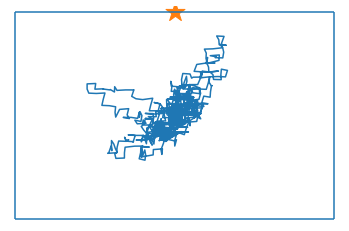

In [50]:
state = np.array([0, 0])
goal = np.array([0, 1])

state = env.reset_pos(state)

traj = {'desired_goal': goal}
states = []
count = 1
while np.linalg.norm(state - goal) >= 0.05:
    reach = reachable_set.get_reachable_set(state, threshold=10)
    reach_center = reachable_set.get_reachable_set_center_state(reach)
    # print(reach_center)
    min_dist = np.linalg.norm(state - goal)
    min_state = [0, 0]
    for rc in reach_center:
        if np.linalg.norm(np.array(rc) - goal) <= min_dist:
            min_dist = np.linalg.norm(rc - goal)
            min_state = rc
#     plt.figure(count)
    bin = reachable_set.bin_check(min_state)
#     sns.heatmap(np.rot90(reachable_set.grid[bin[0]][bin[1]]))
    print(min_state)
    for j in range(20):
        action = agent.get_action(state=state,
                                    goal=min_state,
                                    horizon=np.array(20, dtype=float))
        state, _, _, _ = env.step(action)
        states.append(state)
        if np.linalg.norm(state - np.array(min_state)) <= 0.05:
            break
    count += 1
    if count ==50:
        print('Goal is not reachable')
        break
        
traj['states'] = np.array(states)

print(np.linalg.norm(state - goal))
plt.figure(count)
plot_trajectory(traj)


In [18]:
def get_min_reach_state(state, goal, reachable_set, depth=3):
    reach = reachable_set.get_reachable_set(state, threshold=5)
    reach_center = reachable_set.get_reachable_set_center_state(reach)
    min_state = state
    min_dist = np.linalg.norm((min_state, goal))
    queue = []
    for state in reach_center:
        queue.append((state, state, 1))
        while queue != []:
            prev_state, curr_state, d = queue.pop(0)
            dist = np.linalg.norm(curr_state-goal)
#             print(curr_state, min_dist, dist)
            if dist < min_dist:
                min_state = prev_state
                min_dist = dist
            if d < depth:
                reach_curr = reachable_set.get_reachable_set(curr_state, threshold=10)
                reach_center_curr = reachable_set.get_reachable_set_center_state(reach_curr)
                for r in reach_center_curr:
                    queue.append((prev_state, r, d+1))
    return min_state
        
get_min_reach_state((0, 0), (1, 0), reachable_set, 1)

array([0.22, 0.1 ])

[0.22 0.42]
[0.3  0.22]
[0.34 0.46]
[0.26 0.34]
[0.22 0.38]
[0.22 0.38]
[0.26 0.58]
[0.26 0.66]
[0.06 0.66]
[0.1  0.66]
[-0.06  0.74]
[0.1086578 0.5586578]
[0.12538244 0.57538244]
[-0.02  0.78]
[0.05622592 0.55622592]
[0.06137165 0.56137165]
[0.04747727 0.59747727]
[-0.00247783  0.59752217]
[-0.02  0.78]
[-0.06  0.74]
[-0.02  0.78]
[-0.02697545  0.82302455]
[-0.02709099  0.82290901]
[-0.02  0.86]
[-0.02  0.86]
[0.02 0.86]
[0.02 0.86]
[0.01655336 0.81655336]
[0.02187785 0.82187785]
[-0.02  0.78]
[-0.02  0.78]
[-0.02  0.78]
[-0.02  0.78]
[-0.0201214  0.7298786]
[-0.1  0.7]
[0.14414814 0.69414814]
[0.15941024 0.65941024]
[0.18 0.62]
[0.26 0.66]
[0.26 0.66]
[0.28519532 0.68519532]
[0.3233836 0.8233836]
[0.38 0.78]
[0.34 0.74]
[0.1  0.94]
[0.1  0.94]
0.03665381883012101


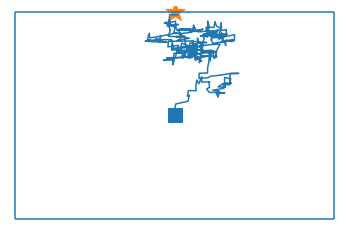

In [60]:
state = np.array([0, 0])
goal = np.array([0, 1])

state = env.reset_pos(state)

traj = {'desired_goal': goal}
states = []
count = 1
while np.linalg.norm(state - goal) >= 0.05:
    min_state = get_min_reach_state(state, goal, reachable_set, depth=2)
    print(min_state)

    for j in range(20):
        action = agent.get_action(state=state,
                                    goal=min_state,
                                    horizon=np.array(20, dtype=float))
        state, _, _, _ = env.step(action)
        states.append(state)
        if np.linalg.norm(state - np.array(min_state)) <= 0.05:
            break
    count += 1
    if count ==100:
        print('Goal is not reachable')
        break
        
traj['states'] = np.array(states)

print(np.linalg.norm(state - goal))
plt.figure(count)
plot_trajectory(traj)


[0.22 0.42]
[0.22 0.42]
[-0.02  0.38]
[-0.1   0.78]
[-0.06  0.86]
[0.1  0.86]
[-0.02  0.7 ]
[0.06 0.74]
[-0.1  0.7]
[-0.1   0.86]
[-0.1   0.86]
[-0.06  0.86]
[-0.06  0.9 ]
[-0.17592313  0.97030991]
[-0.14  0.94]
[-0.16893466  0.97729838]
[-0.14  0.94]
[-0.14  0.94]
[-0.14  0.94]
[-0.14  0.94]
[-0.14  0.94]
[-0.14  0.94]
[-0.1   0.98]
[-0.1   0.98]
[-0.06  0.98]
[-0.06  0.98]
0.020019493330036706


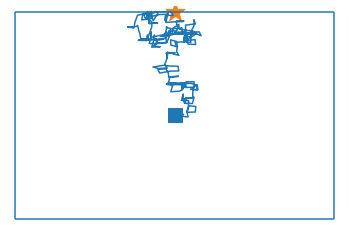

In [68]:
state = np.array([0, 0])
goal = np.array([0, 1])

state = env.reset_pos(state)

traj = {'desired_goal': goal}
states = []
count = 1
while np.linalg.norm(state - goal) >= 0.05:
    min_state = get_min_reach_state(state, goal, reachable_set, depth=2)
    print(min_state)

    for j in range(20):
        action = agent.get_action(state=state,
                                    goal=min_state,
                                    horizon=np.array(20, dtype=float))
        state, _, _, _ = env.step(action)
        states.append(state)
        if np.linalg.norm(state - np.array(min_state)) <= 0.05:
            break
    count += 1
    if count ==100:
        print('Goal is not reachable')
        break
        
traj['states'] = np.array(states)

print(np.linalg.norm(state - goal))
plt.figure(count)
plot_trajectory(traj)

## What about reachable set not connected?

In [29]:
reachable_set = ReachableSet(env, 'pointmass_empty', 50, 50)
reachable_set.grid_init()

<AxesSubplot:>

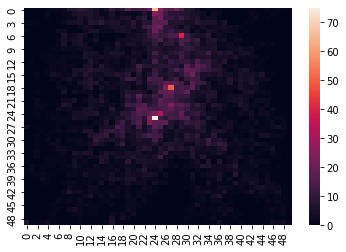

In [31]:
trajs = []
buffer = []
for i in range(50):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0, 0))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)

for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0.1, 0.25))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0.2, 0.75))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
for i in range(50):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0, 1))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for traj in trajs:
    for s in traj:
        b = r.bin_check(s)
        r.grid[0][0][b[0]][b[1]] += 1

sns.heatmap(np.rot90(r.grid[0][0]))

<AxesSubplot:>

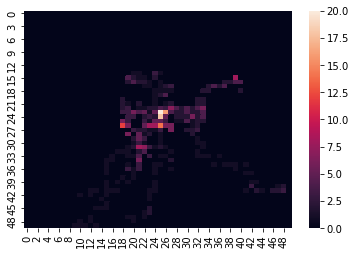

In [26]:
import seaborn as sns
sns.heatmap(np.rot90(reachable_set.grid[25][25]))

In [11]:
# Create agent and optimizer
agent = NNAgent()
learning_rate = 1e-4
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

n_episodes = 501
n_steps_per_episode = 1000

for episode in range(n_episodes):
  # Collect more data and put it in the replay buffer
  # new_trajectory = sample_trajectory(env, agent)
  # buffer.append(new_trajectory)

  # GCSL optimization  
  for step in range(n_steps_per_episode):

    # Sample a trajectory and timesteps
    trajectory = buffer[np.random.choice(len(buffer))]
    t1, t2 = np.random.randint(0, 50, size=2)
    t1, t2 = min([t1, t2]), max([t1, t2])

    # Create optimal ((s, g, h), a) data
    s = trajectory['states'][t1]
    g = trajectory['states'][t2]
    h = t2 - t1
    a = trajectory['actions'][t1]

    s, g, h = to_torch(s, g, h)
    a = torch.tensor(a)[None]

    # Optimize agent(s, g, h) to imitate action a 
    optimizer.zero_grad()
    loss = nn.functional.cross_entropy(agent(s, g, h), a)
    loss.backward()
    optimizer.step()

  # Print agent performance once in a while
  if episode % 40 == 0:
    print('##### Episode %d #####'%episode)
    evaluate_agent(env, agent)

##### Episode 0 #####
Median Distance to Goal:  0.724
Min Distance to Goal:  0.172
Max Distance to Goal:  1.490
##### Episode 40 #####
Median Distance to Goal:  0.220
Min Distance to Goal:  0.030
Max Distance to Goal:  0.574
##### Episode 80 #####
Median Distance to Goal:  0.126
Min Distance to Goal:  0.017
Max Distance to Goal:  0.576
##### Episode 120 #####
Median Distance to Goal:  0.111
Min Distance to Goal:  0.020
Max Distance to Goal:  0.424
##### Episode 160 #####
Median Distance to Goal:  0.114
Min Distance to Goal:  0.012
Max Distance to Goal:  0.327
##### Episode 200 #####
Median Distance to Goal:  0.091
Min Distance to Goal:  0.017
Max Distance to Goal:  0.290
##### Episode 240 #####
Median Distance to Goal:  0.090
Min Distance to Goal:  0.007
Max Distance to Goal:  0.287
##### Episode 280 #####
Median Distance to Goal:  0.059
Min Distance to Goal:  0.005
Max Distance to Goal:  0.194
##### Episode 320 #####
Median Distance to Goal:  0.085
Min Distance to Goal:  0.019
Max Dis

[-0.18  0.42]
[0, 0]
[-0.14  0.18]
[0, 0]
[0.02 0.3 ]
[0.06 0.18]
[0.18 0.18]
[0.3 0.3]
[0.18 0.18]
[0.06 0.18]
[0, 0]
[0.14 0.1 ]
[0, 0]
[0.14 0.1 ]
[0, 0]
[-0.1   0.22]
[-0.1  0.1]
[-0.14  0.18]
[0, 0]
[0, 0]
[-0.18  0.42]
[-0.18  0.42]
[-0.18  0.42]
[0, 0]
[0, 0]
[-0.06  0.14]
[-0.22  0.18]
[-0.02  0.18]
[0.02 0.22]
[-0.18  0.42]
[0, 0]
[0.1  0.06]
[0.06 0.14]
[0.18 0.18]
[-0.1   0.26]
[-0.06  0.26]
[-0.06  0.26]
[-0.06  0.26]
[-0.18  0.46]
[0, 0]
[0, 0]
[-0.06  0.14]
[-0.18  0.46]
[0, 0]
[0.02 0.38]
[0.18 0.5 ]
[0, 0]
[0.26 0.18]
[0.22 0.18]
Goal is not reachable
0.7382771045803039


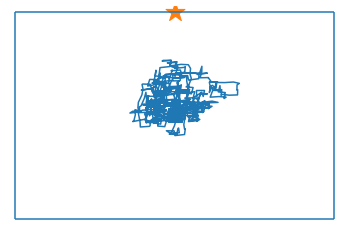

In [12]:
state = np.array([0, 0])
goal = np.array([0, 1])

state = env.reset_pos(state)

traj = {'desired_goal': goal}
states = []
count = 1
while np.linalg.norm(state - goal) >= 0.05:
    reach = reachable_set.get_reachable_set(state, threshold=10)
    reach_center = reachable_set.get_reachable_set_center_state(reach)
    # print(reach_center)
    min_dist = np.linalg.norm(state - goal)
    min_state = [0, 0]
    for rc in reach_center:
        if np.linalg.norm(np.array(rc) - goal) <= min_dist:
            min_dist = np.linalg.norm(rc - goal)
            min_state = rc
#     plt.figure(count)
    bin = reachable_set.bin_check(min_state)
#     sns.heatmap(np.rot90(reachable_set.grid[bin[0]][bin[1]]))
    print(min_state)
    for j in range(20):
        action = agent.get_action(state=state,
                                    goal=min_state,
                                    horizon=np.array(20, dtype=float))
        state, _, _, _ = env.step(action)
        states.append(state)
        if np.linalg.norm(state - np.array(min_state)) <= 0.05:
            break
    count += 1
    if count ==50:
        print('Goal is not reachable')
        break
        
traj['states'] = np.array(states)

print(np.linalg.norm(state - goal))
plt.figure(count)
plot_trajectory(traj)


In [32]:
for i in range(30):
    traj = sample_trajectory_random(env, agent, fixed_init_state=(0.08, 0.4))
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)

<AxesSubplot:>

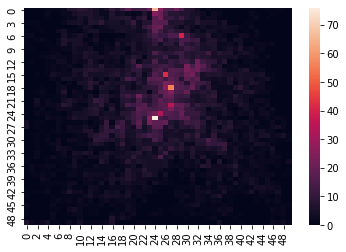

In [33]:
r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for traj in trajs:
    for s in traj:
        b = r.bin_check(s)
        r.grid[0][0][b[0]][b[1]] += 1

sns.heatmap(np.rot90(r.grid[0][0]))

In [34]:
# Create agent and optimizer
agent = NNAgent()
learning_rate = 1e-4
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

n_episodes = 501
n_steps_per_episode = 1000

for episode in range(n_episodes):
  # Collect more data and put it in the replay buffer
  # new_trajectory = sample_trajectory(env, agent)
  # buffer.append(new_trajectory)

  # GCSL optimization  
  for step in range(n_steps_per_episode):

    # Sample a trajectory and timesteps
    trajectory = buffer[np.random.choice(len(buffer))]
    t1, t2 = np.random.randint(0, 50, size=2)
    t1, t2 = min([t1, t2]), max([t1, t2])

    # Create optimal ((s, g, h), a) data
    s = trajectory['states'][t1]
    g = trajectory['states'][t2]
    h = t2 - t1
    a = trajectory['actions'][t1]

    s, g, h = to_torch(s, g, h)
    a = torch.tensor(a)[None]

    # Optimize agent(s, g, h) to imitate action a 
    optimizer.zero_grad()
    loss = nn.functional.cross_entropy(agent(s, g, h), a)
    loss.backward()
    optimizer.step()

  # Print agent performance once in a while
  if episode % 40 == 0:
    print('##### Episode %d #####'%episode)
    evaluate_agent(env, agent)

##### Episode 0 #####
Median Distance to Goal:  0.629
Min Distance to Goal:  0.063
Max Distance to Goal:  1.694
##### Episode 40 #####
Median Distance to Goal:  0.134
Min Distance to Goal:  0.015
Max Distance to Goal:  0.592
##### Episode 80 #####
Median Distance to Goal:  0.106
Min Distance to Goal:  0.014
Max Distance to Goal:  0.390
##### Episode 120 #####
Median Distance to Goal:  0.084
Min Distance to Goal:  0.011
Max Distance to Goal:  0.237
##### Episode 160 #####
Median Distance to Goal:  0.069
Min Distance to Goal:  0.009
Max Distance to Goal:  0.174
##### Episode 200 #####
Median Distance to Goal:  0.073
Min Distance to Goal:  0.004
Max Distance to Goal:  0.185
##### Episode 240 #####
Median Distance to Goal:  0.060
Min Distance to Goal:  0.011
Max Distance to Goal:  0.185
##### Episode 280 #####
Median Distance to Goal:  0.058
Min Distance to Goal:  0.003
Max Distance to Goal:  0.158
##### Episode 320 #####
Median Distance to Goal:  0.056
Min Distance to Goal:  0.007
Max Dis

[-0.06  0.06]
[0.02 0.86]
[-0.06  0.7 ]
[-0.14  0.46]
[-0.14  0.58]
[-0.14  0.58]
[-0.06  0.54]
[-0.06  0.7 ]
[-0.06  0.7 ]
[0.18 0.74]
[-0.02  0.66]
[0.02 0.66]
[-0.02  0.62]
[-0.02  0.58]
[-0.06  0.66]
[0.02 0.74]
[0.02 0.74]
[0.02 0.74]
[0.02 0.74]
[-0.02  0.78]
[-0.02  0.82]
[0.02 0.9 ]
[-0.02  0.9 ]
[-0.06  0.98]
0.03247159413337569


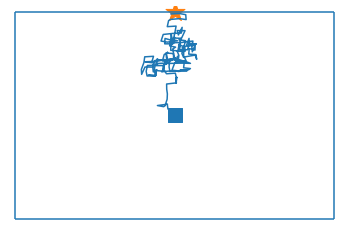

In [38]:
state = np.array([0, 0])
goal = np.array([0, 1])

state = env.reset_pos(state)

traj = {'desired_goal': goal}
states = []
count = 1
while np.linalg.norm(state - goal) >= 0.05:
    min_state = get_min_reach_state(state, goal, reachable_set, depth=2)
    print(min_state)

    for j in range(20):
        action = agent.get_action(state=state,
                                    goal=min_state,
                                    horizon=np.array(20, dtype=float))
        state, _, _, _ = env.step(action)
        states.append(state)
        if np.linalg.norm(state - np.array(min_state)) <= 0.05:
            break
    count += 1
    if count ==100:
        print('Goal is not reachable')
        break
        
traj['states'] = np.array(states)

print(np.linalg.norm(state - goal))
plt.figure(count)
plot_trajectory(traj)

## From Discrete to Continuous

In [17]:
reachable_set = ReachableSet(env, 'pointmass_empty', 50, 50)
reachable_set.grid_init()

<AxesSubplot:>

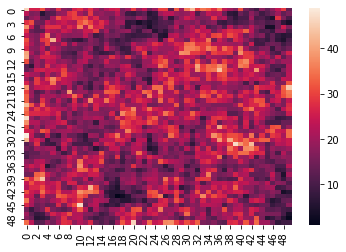

In [18]:
trajs = []
buffer = []
for i in range(1000):
    traj = sample_trajectory_random(env, agent)
    reachable_set.grid_update_traj(traj['states'])
    trajs.append(traj['states'])
    buffer.append(traj)
    
r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for traj in trajs:
    for s in traj:
        b = r.bin_check(s)
        r.grid[0][0][b[0]][b[1]] += 1
import seaborn as sns
sns.heatmap(r.grid[0][0])

In [19]:
# Create agent and optimizer
agent1 = NNAgent()
agent2 = NNAgent()
agent3 = NNAgent()
# agent4 = NNAgent()
# agent5 = NNAgent()
learning_rate = 1e-4
optimizer1 = torch.optim.Adam(agent1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(agent2.parameters(), lr=learning_rate)
optimizer3 = torch.optim.Adam(agent3.parameters(), lr=learning_rate)
# optimizer4 = torch.optim.Adam(agent4.parameters(), lr=learning_rate)
# optimizer5 = torch.optim.Adam(agent5.parameters(), lr=learning_rate)

n_episodes = 51
n_steps_per_episode = 1000

for episode in range(n_episodes):
  # Collect more data and put it in the replay buffer
  # new_trajectory = sample_trajectory(env, agent)
  # buffer.append(new_trajectory)

  # GCSL optimization  
  for step in range(n_steps_per_episode):

    # Sample a trajectory and timesteps
    trajectory = buffer[np.random.choice(len(buffer))]
    t1, t2 = np.random.randint(0, 50, size=2)
    t1, t2 = min([t1, t2]), max([t1, t2])

    # Create optimal ((s, g, h), a) data
    s = trajectory['states'][t1]
    g = trajectory['states'][t2]
    h = t2 - t1
    a = trajectory['actions'][t1]

    s, g, h = to_torch(s, g, h)
    a = torch.tensor(a)[None]

    # Optimize agent(s, g, h) to imitate action a 
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
#     optimizer4.zero_grad()
#     optimizer5.zero_grad()
    loss1 = nn.functional.cross_entropy(agent1(s, g, h), a)
    loss1.backward()
    loss2 = nn.functional.cross_entropy(agent2(s, g, h), a)
    loss2.backward()
    loss3 = nn.functional.cross_entropy(agent3(s, g, h), a)
    loss3.backward()
#     loss4 = nn.functional.cross_entropy(agent4(s, g, h), a)
#     loss4.backward()
#     loss5 = nn.functional.cross_entropy(agent5(s, g, h), a)
#     loss5.backward()
    
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()
#     optimizer4.step()
#     optimizer5.step()

  # Print agent performance once in a while
  if episode % 40 == 0:
    print('##### Episode %d #####'%episode)
    evaluate_agent(env, agent1)
    evaluate_agent(env, agent2)
    evaluate_agent(env, agent3)
#     evaluate_agent(env, agent4)
#     evaluate_agent(env, agent5)

##### Episode 0 #####
Median Distance to Goal:  0.790
Min Distance to Goal:  0.158
Max Distance to Goal:  1.440
Median Distance to Goal:  0.860
Min Distance to Goal:  0.095
Max Distance to Goal:  1.416
Median Distance to Goal:  0.879
Min Distance to Goal:  0.084
Max Distance to Goal:  1.469
##### Episode 40 #####
Median Distance to Goal:  0.164
Min Distance to Goal:  0.020
Max Distance to Goal:  0.664
Median Distance to Goal:  0.250
Min Distance to Goal:  0.025
Max Distance to Goal:  0.533
Median Distance to Goal:  0.231
Min Distance to Goal:  0.013
Max Distance to Goal:  0.748


In [45]:
state = np.array([0, 0])
goal = np.array([0, 0])
action1 = agent1.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
action2 = agent2.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
action3 = agent3.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
print(np.var([action1, action2, action3]))

0.0008306386


In [46]:
state = np.array([0, 0])
goal = np.array([0, 0.3])
action1 = agent1.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
action2 = agent2.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
action3 = agent3.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
print(np.var([action1, action2, action3]))

0.0031480384


In [47]:
state = np.array([0, 0])
goal = np.array([0, 1])
action1 = agent1.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
action2 = agent2.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
action3 = agent3.get_action_dist(state=state,
                                    goal=goal,
                                    horizon=np.array(50, dtype=float))
print(np.var([action1, action2, action3]))

0.043661814


[Text(0.5, 1.0, 'Continuous State Space')]

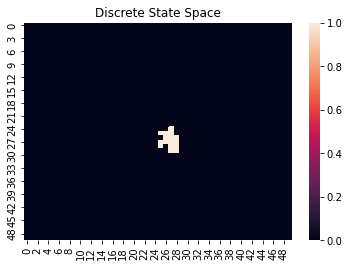

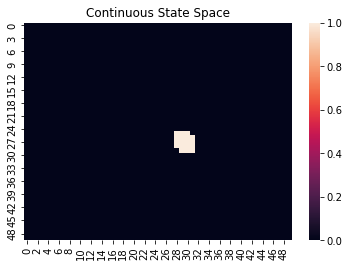

In [38]:
state = [0.1, 0.1]

all_states = [(i, j) for i in range(50) for j in range(50)]
all_goals = reachable_set.get_reachable_set_center_state(all_states)
goals = reachable_set.get_reachable_set_center_state(reachable_set.get_reachable_set(state, threshold=10))

count = 0 
reached_goals = []

for g in all_goals:
    action1 = agent1.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    action2 = agent2.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    action3 = agent3.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    if np.var([action1, action2, action3]) <= 0.0009:
        reached_goals.append(g)
        count += 1

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for s in goals:
    b = r.bin_check(s)
    r.grid[0][0][b[0]][b[1]] += 1
sns.heatmap(r.grid[0][0]).set(title='Discrete State Space')

plt.figure(count)

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for s in reached_goals:
    b = r.bin_check(s)
    r.grid[0][0][b[0]][b[1]] += 1
sns.heatmap(r.grid[0][0]).set(title='Continuous State Space')

[Text(0.5, 1.0, 'Continuous State Space')]

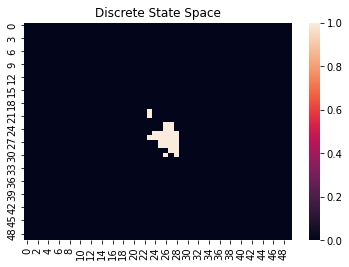

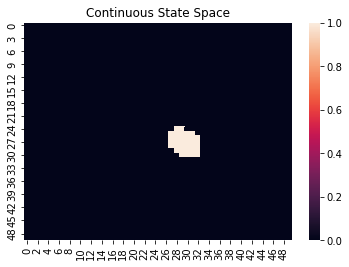

In [40]:
state = [0.1, 0.1]

all_states = [(i, j) for i in range(50) for j in range(50)]
all_goals = reachable_set.get_reachable_set_center_state(all_states)
goals = reachable_set.get_reachable_set_center_state(reachable_set.get_reachable_set(state, threshold=5))

count = 0 
reached_goals = []

for g in all_goals:
    action1 = agent1.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    action2 = agent2.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    action3 = agent3.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    if np.var([action1, action2, action3]) <= 0.0015:
        reached_goals.append(g)
        count += 1

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for s in goals:
    b = r.bin_check(s)
    r.grid[0][0][b[0]][b[1]] += 1
sns.heatmap(r.grid[0][0]).set(title='Discrete State Space')

plt.figure(count)

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for s in reached_goals:
    b = r.bin_check(s)
    r.grid[0][0][b[0]][b[1]] += 1
sns.heatmap(r.grid[0][0]).set(title='Continuous State Space')

[Text(0.5, 1.0, 'Continuous State Space')]

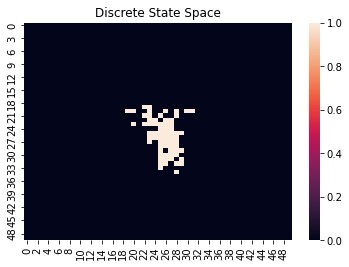

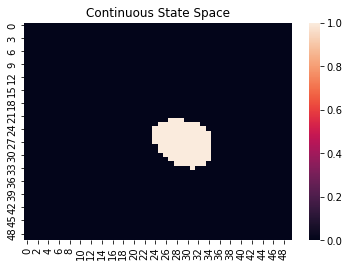

In [44]:
state = [0.1, 0.1]

all_states = [(i, j) for i in range(50) for j in range(50)]
all_goals = reachable_set.get_reachable_set_center_state(all_states)
goals = reachable_set.get_reachable_set_center_state(reachable_set.get_reachable_set(state, threshold=2))

count = 0 
reached_goals = []

for g in all_goals:
    action1 = agent1.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    action2 = agent2.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    action3 = agent3.get_action_dist(state=state,
                                    goal=g,
                                    horizon=np.array(50, dtype=float))
    if np.var([action1, action2, action3]) <= 0.0035:
        reached_goals.append(g)
        count += 1

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for s in goals:
    b = r.bin_check(s)
    r.grid[0][0][b[0]][b[1]] += 1
sns.heatmap(r.grid[0][0]).set(title='Discrete State Space')

plt.figure(count)

r = ReachableSet(env, 'pointmass_empty', 50, 50)
r.grid_init()
for s in reached_goals:
    b = r.bin_check(s)
    r.grid[0][0][b[0]][b[1]] += 1
sns.heatmap(r.grid[0][0]).set(title='Continuous State Space')